In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.stats.mstats import gmean
import xgboost as xgb
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fpath = "/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/intermediate_files"

In [2]:
df = pd.read_stata(fpath + "/full_data_truncated.dta")

In [3]:
# Exclude NSC predictors
nsc_predictors = ['pre_num_nsc_coll', 'num_nsc_coll', 'pre_nsc_terms', 'nsc_terms', 
                  'enrolled_nsc','admrate','gradrate','satvr25','satvr75','satmt25', 'satmt75','satwr25','satwr75',
                  'nsc_coll_type_1', 'nsc_coll_type_2', 'nsc_coll_type_3', 'nsc_coll_type_4',
                  'nsc_coll_type_5','nsc_coll_type_6','nsc_coll_type_7', 'nsc_coll_type_8'] + \
                 [e1+e2+str(e3) for e1 in ['enrolled_nsc_', 'enrl_intensity_nsc_'] for e2 in ['fa','su','sp'] for e3 in range(1,7)]
predictors = np.setdiff1d(list(df.columns.values)[10:], nsc_predictors)
print(len(predictors))

274


In [4]:
impute_list_1 = set(["prop_comp_pre","cum_gpa_pre"])
impute_list_2 = set([t1+"_"+t2+str(t3) for t1 in ["term_gpa", "prop_comp", "lvl2_prop_comp", "dev_prop_comp"] for t2 in ["fa", "sp", "su"] for t3 in range(1,7,1)])
impute_list_3 = set(["cum_gpa", "lvl2_prop_comp", "dev_prop_comp", "prop_comp", "prop_comp_sd", "withdrawn_prop_comp_sd"])
impute_list_4 = set(["admrate", "gradrate", "satvr25", "satvr75", "satmt25", "satmt75", "satwr25", "satwr75"])

In [5]:
# Exclude NSC enrollees
train_df = df[np.array(df.valid == 0) & np.array(df.enrolled_nsc == 0)]
test_df = df[np.array(df.valid == 1) & np.array(df.enrolled_nsc == 0)]
print(train_df.shape,test_df.shape)

(281317, 341) (31200, 341)


In [6]:
def impute(train, test):
    for p in impute_list_1:
        avg_p = np.nanmean(train[train.enrolled_pre == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_3:
        avg_p = np.nanmean(train[p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_2:
        suffix = p[-3:]
        avg_p = np.nanmean(train[train["enrolled_" + suffix] == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_4:
        avg_p = np.nanmean(train[train["enrolled_nsc"] == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    return train, test 

In [7]:
train_df_new, test_df_new = impute(train_df, test_df)
X_train = train_df_new.loc[:,predictors]
y_train = train_df_new.grad_6years
X_test = test_df_new.loc[:,predictors]
y_test = test_df_new.grad_6years

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


In [8]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [9]:
np.random.seed(4321)
val_indices = np.random.choice(train_df.shape[0], int(np.floor(train_df.shape[0]*0.15)), replace=False)
train_val = train_df.iloc[val_indices,:]
train_train = train_df.iloc[np.setdiff1d(np.arange(train_df.shape[0]), val_indices),:]
train_train_new, train_val_new = impute(train_train, train_val)
X_train_train = train_train_new.loc[:,predictors]
y_train_train = train_train_new.grad_6years
X_train_val = train_val_new.loc[:,predictors]
y_train_val = train_val_new.grad_6years

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


In [10]:
dtrain_train = xgb.DMatrix(X_train_train, y_train_train)
dtrain_val = xgb.DMatrix(X_train_val, y_train_val)

In [11]:
results_dir = "C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\truncated_new_3\\"

#### (1) Grid Search for max_depth and eta (learning rate)

In [12]:
grid_1 = [(md,e) for md in range(4,8) for e in [0.01, 0.02, 0.05, 0.1, 0.2]]
validation_auc_1 = Counter()
for md,e in grid_1:
    print("max_depth = {0}, eta = {1}:".format(md,e))
    params = {'max_depth': md, 'eta': e, 'min_child_weight': 1, 'colsample_bytree': 0.8, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_1[(md,e)] = np.max(evals_result['validation']['auc'])
    print("")

max_depth = 4, eta = 0.01:
[0]	validation-auc:0.822074
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.848012
[100]	validation-auc:0.855715
[150]	validation-auc:0.860499
[200]	validation-auc:0.864229
[250]	validation-auc:0.867055
[300]	validation-auc:0.869255
[350]	validation-auc:0.871302
[400]	validation-auc:0.873048
[450]	validation-auc:0.874483
[500]	validation-auc:0.87574
[550]	validation-auc:0.876848
[600]	validation-auc:0.877927
[650]	validation-auc:0.878856
[700]	validation-auc:0.879688
[750]	validation-auc:0.880447
[800]	validation-auc:0.881106
[850]	validation-auc:0.881678
[900]	validation-auc:0.882205
[950]	validation-auc:0.882682
[1000]	validation-auc:0.883108
[1050]	validation-auc:0.883489
[1100]	validation-auc:0.883839
[1150]	validation-auc:0.884171
[1200]	validation-auc:0.884481
[1250]	validation-auc:0.884755
[1300]	validation-auc:0.885021
[1350]	validation-auc:0.885311
[1400]	validation-auc:0.885568
[1450]	validation-auc:0.885829
[1500

[1950]	validation-auc:0.894077
[2000]	validation-auc:0.894172
Stopping. Best iteration:
[2000]	validation-auc:0.894172


max_depth = 5, eta = 0.05:
[0]	validation-auc:0.832402
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.871478
[100]	validation-auc:0.879825
[150]	validation-auc:0.884114
[200]	validation-auc:0.886518
[250]	validation-auc:0.887944
[300]	validation-auc:0.888937
[350]	validation-auc:0.889968
[400]	validation-auc:0.890641
[450]	validation-auc:0.891331
[500]	validation-auc:0.891883
[550]	validation-auc:0.892135
[600]	validation-auc:0.892428
[650]	validation-auc:0.892746
[700]	validation-auc:0.893041
[750]	validation-auc:0.893256
[800]	validation-auc:0.893429
[850]	validation-auc:0.893604
[900]	validation-auc:0.893829
[950]	validation-auc:0.89406
[1000]	validation-auc:0.894194
Stopping. Best iteration:
[1007]	validation-auc:0.894222


max_depth = 5, eta = 0.1:
[0]	validation-auc:0.832402
Will train until validation-auc hasn't improved in

In [13]:
for t in validation_auc_1.most_common():
    print(t)

((7, 0.01), 0.895446)
((6, 0.02), 0.895113)
((7, 0.02), 0.895064)
((7, 0.05), 0.894524)
((6, 0.05), 0.894437)
((5, 0.05), 0.894222)
((5, 0.02), 0.894172)
((7, 0.1), 0.89411)
((6, 0.1), 0.893729)
((5, 0.1), 0.89365)
((4, 0.1), 0.893471)
((4, 0.02), 0.893321)
((4, 0.05), 0.892624)
((4, 0.01), 0.892403)
((7, 0.2), 0.892232)
((6, 0.2), 0.891957)
((4, 0.2), 0.891598)
((5, 0.2), 0.891408)
((6, 0.01), 0.860803)
((5, 0.01), 0.853624)


#### (2) Grid Search for min_child_weight (along with max_depth)

In [14]:
md1 = 6
grid_2 = [(md1+i,mcw) for i in [-1,0,1] for mcw in [3,5]]
validation_auc_2 = Counter()
for md,mcw in grid_2:
    print("max_depth = {0}, min_child_weight = {1}:".format(md,mcw))
    params = {'max_depth': md, 'eta': 0.02, 'min_child_weight': mcw, 'colsample_bytree': 0.8, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_2[(md,mcw)] = np.max(evals_result['validation']['auc'])
    print("")

max_depth = 5, min_child_weight = 3:
[0]	validation-auc:0.832402
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.86195
[100]	validation-auc:0.869302
[150]	validation-auc:0.873894
[200]	validation-auc:0.877387
[250]	validation-auc:0.880038
[300]	validation-auc:0.88205
[350]	validation-auc:0.883775
[400]	validation-auc:0.884924
[450]	validation-auc:0.886027
[500]	validation-auc:0.886772
[550]	validation-auc:0.887435
[600]	validation-auc:0.887983
[650]	validation-auc:0.888506
[700]	validation-auc:0.88903
[750]	validation-auc:0.889492
[800]	validation-auc:0.889875
[850]	validation-auc:0.890218
[900]	validation-auc:0.890547
[950]	validation-auc:0.890841
[1000]	validation-auc:0.891119
[1050]	validation-auc:0.891369
[1100]	validation-auc:0.891627
[1150]	validation-auc:0.891814
[1200]	validation-auc:0.892049
[1250]	validation-auc:0.892201
[1300]	validation-auc:0.892364
[1350]	validation-auc:0.892541
[1400]	validation-auc:0.892681
[1450]	validation-auc:0.8928

In [15]:
for t in validation_auc_2.most_common():
    print(t)

((6, 3), 0.895517)
((7, 5), 0.895469)
((7, 3), 0.89543)
((6, 5), 0.894985)
((5, 3), 0.894183)
((5, 5), 0.894129)


#### (3) Grid Search for colsample_by_tree

In [16]:
grid_3 = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
validation_auc_3 = Counter()
for cbt in grid_3:
    print("colsample_by_tree = {}:".format(cbt))
    params = {'max_depth': 6, 'eta': 0.02, 'min_child_weight': 3, 'colsample_bytree': cbt, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_3[cbt] = np.max(evals_result['validation']['auc'])
    print("")

colsample_by_tree = 0.5:
[0]	validation-auc:0.837658
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.868974
[100]	validation-auc:0.874169
[150]	validation-auc:0.878103
[200]	validation-auc:0.881113
[250]	validation-auc:0.883452
[300]	validation-auc:0.885249
[350]	validation-auc:0.886783
[400]	validation-auc:0.887795
[450]	validation-auc:0.888642
[500]	validation-auc:0.889417
[550]	validation-auc:0.889958
[600]	validation-auc:0.890452
[650]	validation-auc:0.890806
[700]	validation-auc:0.891215
[750]	validation-auc:0.891623
[800]	validation-auc:0.892029
[850]	validation-auc:0.892306
[900]	validation-auc:0.89251
[950]	validation-auc:0.892735
[1000]	validation-auc:0.892923
[1050]	validation-auc:0.893125
[1100]	validation-auc:0.893339
[1150]	validation-auc:0.893517
[1200]	validation-auc:0.893688
[1250]	validation-auc:0.893845
[1300]	validation-auc:0.893978
[1350]	validation-auc:0.894133
[1400]	validation-auc:0.894251
[1450]	validation-auc:0.894367
[1500]	

[600]	validation-auc:0.890801
[650]	validation-auc:0.891212
[700]	validation-auc:0.891605
[750]	validation-auc:0.891944
[800]	validation-auc:0.892261
[850]	validation-auc:0.892586
[900]	validation-auc:0.892858
[950]	validation-auc:0.893034
[1000]	validation-auc:0.893237
[1050]	validation-auc:0.893393
[1100]	validation-auc:0.893572
[1150]	validation-auc:0.893721
[1200]	validation-auc:0.893903
[1250]	validation-auc:0.894057
[1300]	validation-auc:0.894194
[1350]	validation-auc:0.894276
[1400]	validation-auc:0.894364
[1450]	validation-auc:0.894441
[1500]	validation-auc:0.894579
[1550]	validation-auc:0.894673
[1600]	validation-auc:0.89478
[1650]	validation-auc:0.894911
[1700]	validation-auc:0.895004
[1750]	validation-auc:0.895097
[1800]	validation-auc:0.89518
[1850]	validation-auc:0.895268
[1900]	validation-auc:0.89535
[1950]	validation-auc:0.895433
[2000]	validation-auc:0.895512
Stopping. Best iteration:
[1996]	validation-auc:0.895517


colsample_by_tree = 0.85:
[0]	validation-auc:0.841571

In [18]:
validation_auc_3.most_common()

[(0.55, 0.895538),
 (0.75, 0.895521),
 (0.8, 0.895517),
 (0.9, 0.895404),
 (0.65, 0.895239),
 (0.6, 0.895231),
 (0.5, 0.895222),
 (0.85, 0.894707),
 (0.7, 0.894465)]

#### (4) Finally select the opitmal num_boost_round

In [19]:
params = {'max_depth': 6, 'eta': 0.02, 'min_child_weight': 3, 'colsample_bytree': 0.8, 
          'subsample': 0.8, 
          'objective': 'binary:logistic', 'eval_metric': ['auc'],
          'seed': 12345}
evals_result = {}
xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                      early_stopping_rounds = 10,
                      evals_result = evals_result,
                      verbose_eval = 50)
optimal_num_boost_round = np.argmax(evals_result['validation']['auc'])
print("")
print(optimal_num_boost_round)

[0]	validation-auc:0.840533
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.867205
[100]	validation-auc:0.873946
[150]	validation-auc:0.877918
[200]	validation-auc:0.881197
[250]	validation-auc:0.883693
[300]	validation-auc:0.885589
[350]	validation-auc:0.887036
[400]	validation-auc:0.888087
[450]	validation-auc:0.888961
[500]	validation-auc:0.889618
[550]	validation-auc:0.890264
[600]	validation-auc:0.890801
[650]	validation-auc:0.891212
[700]	validation-auc:0.891605
[750]	validation-auc:0.891944
[800]	validation-auc:0.892261
[850]	validation-auc:0.892586
[900]	validation-auc:0.892858
[950]	validation-auc:0.893034
[1000]	validation-auc:0.893237
[1050]	validation-auc:0.893393
[1100]	validation-auc:0.893572
[1150]	validation-auc:0.893721
[1200]	validation-auc:0.893903
[1250]	validation-auc:0.894057
[1300]	validation-auc:0.894194
[1350]	validation-auc:0.894276
[1400]	validation-auc:0.894364
[1450]	validation-auc:0.894441
[1500]	validation-auc:0.894579


#### (5) Train the final xgb model and make predictions for observations in the test set

In [18]:
optimal_num_boost_round = 1996

In [19]:
# specify parameters via map
params = {'max_depth': 6, 'eta': 0.02, 'min_child_weight': 3, 'colsample_bytree': 0.8, 
          'subsample': 0.8, 
          'objective': 'binary:logistic', 'eval_metric': ['auc'],
          'seed': 12345}
final_xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = optimal_num_boost_round)
# make prediction for observations in the test set
y_test_pred = final_xgb_model.predict(dtest)

In [20]:
print("XGBoost:")
print("AUC = {}".format(round(roc_auc_score(dtest.get_label(), y_test_pred), 4)))

XGBoost:
AUC = 0.9001


In [21]:
# save the model object and predicted scores on the validation sample to local disk
# pickle.dump(final_xgb_model, open(results_dir + "xgb.p", "wb"))
pickle.dump(list(y_test_pred), open(results_dir + "y_test_pred_xgb.p", "wb"))

In [23]:
feature_importance = pd.DataFrame(list(final_xgb_model.get_fscore().items()), columns=['feature','importance']).sort_values('importance', ascending=False)
feature_importance.loc[:, 'importance'] = feature_importance.loc[:, 'importance'] / sum(feature_importance.loc[:, 'importance'])
yy = feature_importance.loc[:, 'importance'].iloc[:20]
xx = feature_importance.loc[:, 'feature'].iloc[:20]

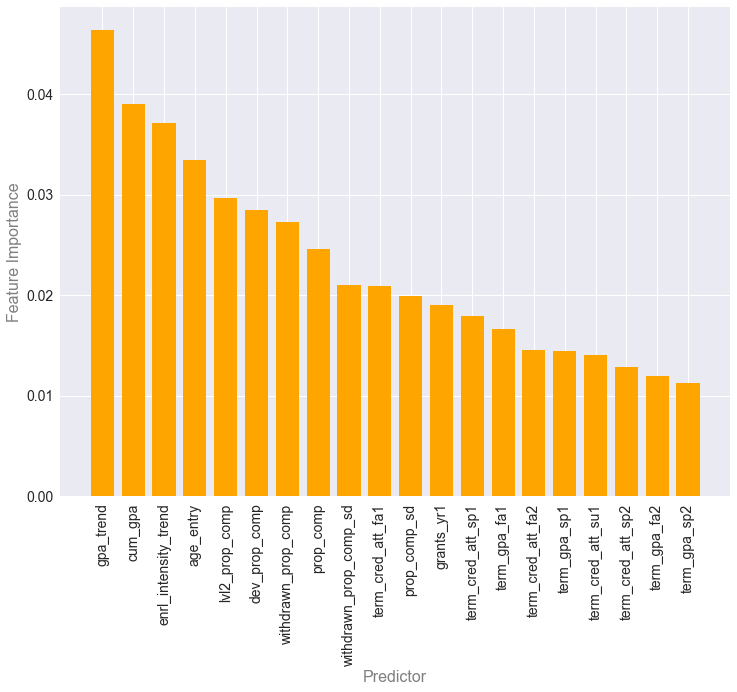

In [25]:
fig = plt.figure(figsize=(12,9))
plt.bar(list(range(20)), yy, width=0.75, color = "orange")
plt.xticks(list(range(20)), xx, rotation = 'vertical', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Predictor", fontsize=16, color="gray")
plt.ylabel("Feature Importance", fontsize=16, color="gray")
plt.savefig(results_dir + "XGBoost_variable_importance.png", bbox_inches='tight')
plt.show()

In [26]:
def find_optimal_threshold(p,r,t):
    to_drop = np.union1d(np.where(pd.isnull(p[:-1]) == True)[0], np.where(pd.isnull(r[:-1]) == True)[0])
    to_drop = np.union1d(to_drop, np.where(pd.isnull(t) == True)[0])
    to_keep = np.setdiff1d(np.array(list(range(len(p)-1))), to_drop)
    p,r,t = p[to_keep],r[to_keep],t[to_keep]
    f1 = 2*p*r/(p+r)
    best_t = t[np.argmax(f1)]
    best_t
    return best_t

def cross_validation(train, xgb_params, nbr):
    threshold_list = []
    auc_list = []
    k_fold =  StratifiedKFold(n_splits = 10, random_state = 12345, shuffle=True)
    for train_indices, test_indices in k_fold.split(train, train.grad_6years):
        train_part = train.iloc[train_indices,:]
        test_part = train.iloc[test_indices,:]
        train_part_new, test_part_new = impute(train_part, test_part)
        X_1 = train_part_new.loc[:,predictors]
        y_1 = train_part_new.grad_6years
        X_2 = test_part_new.loc[:,predictors]
        y_2 = test_part_new.grad_6years
        dtrain_cv = xgb.DMatrix(X_1,y_1)
        dtest_cv = xgb.DMatrix(X_2,y_2)
        xgb_cv_model = xgb.train(params=xgb_params, dtrain=dtrain_cv, num_boost_round = nbr)
        y_2_pred = xgb_cv_model.predict(dtest_cv)
        p,r,t = precision_recall_curve(y_2, y_2_pred)
        auc = roc_auc_score(y_2, y_2_pred)
        threshold_list.append(find_optimal_threshold(p,r,t))
        auc_list.append(auc)
    print(np.mean(auc_list), np.std(auc_list, ddof=1))
    return gmean(threshold_list)

In [27]:
final_params = {'max_depth': 6, 'eta': 0.02, 'min_child_weight': 3, 'colsample_bytree': 0.8, 
                'subsample': 0.8, 
                'objective': 'binary:logistic', 'eval_metric': ['auc'],
                'seed': 12345}
best_threshold = cross_validation(train_df, final_params, optimal_num_boost_round)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\

0.8957661545486127 0.002304700029579016


In [28]:
best_threshold

0.42205945

In [29]:
def create_confusion_matrix(y_test_pred, threshold, fname):
    cm_arr = confusion_matrix(y_test, np.where(y_test_pred > threshold, 1, 0))
    cm_df = pd.DataFrame(cm_arr, columns=['Pred_0','Pred_1'], index=['Real_0', 'Real_1'])
    cm_df.loc[:,''] = cm_df.sum(axis=1)
    cm_df.loc['',:] = cm_df.sum(axis=0)
    print(cm_df)
    print("")
    p1 = cm_df.iloc[1,1]/cm_df.iloc[2,1]
    r1 = cm_df.iloc[1,1]/cm_df.iloc[1,2]
    p0 = cm_df.iloc[0,0]/cm_df.iloc[2,0]
    r0 = cm_df.iloc[0,0]/cm_df.iloc[0,2]    
    print("F1 score = {}".format(round(2*p1*r1/(p1+r1),4)))    
    cm_df.to_csv(results_dir + fname + ".csv")
    return p1,r1,p0,r0,round(2*p1*r1/(p1+r1),4)

In [30]:
print("F1 threshold = {}:\n".format(str(round(best_threshold,3))))
pr_xgb = create_confusion_matrix(y_test_pred, best_threshold, "XGBoost_cm1")

F1 threshold = 0.422:

         Pred_0   Pred_1         
Real_0  18456.0   2446.0  20902.0
Real_1   2480.0   7818.0  10298.0
        20936.0  10264.0  31200.0

F1 score = 0.7604


In [31]:
num_of_0 = int(round((1-np.mean(train_df.grad_6years))*len(y_test)))
y_test_pred_binary = np.ones(len(y_test))
y_test_pred_binary[np.argsort(y_test_pred)[:num_of_0]] = 0
alternative_threshold = y_test_pred[np.argsort(y_test_pred)[num_of_0]]
print("Alternative threshold = {}:\n".format(str(round(alternative_threshold,3))))
pr2_xgb = create_confusion_matrix(y_test_pred_binary, best_threshold, "XGBoost_cm2")

Alternative threshold = 0.419:

         Pred_0   Pred_1         
Real_0  18432.0   2470.0  20902.0
Real_1   2460.0   7838.0  10298.0
        20892.0  10308.0  31200.0

F1 score = 0.7607


In [32]:
precision_recall_df = pd.DataFrame([(best_threshold,)+pr_xgb,(alternative_threshold,)+pr2_xgb]).round(4)
precision_recall_df.index = ['F1','Same_Graduation_Rate']
precision_recall_df.columns = ['threshold','precision_1','recall_1','precision_0','recall_0','f1_score']
precision_recall_df.to_csv(results_dir + "XGBoost_precision_recall.csv", index=True)

#### Reorganize files of key evaluation metrics for the five models fitted on the training sample without NSC enrollees: OLS, Logit, RF, XGBoost, CoxPH

In [13]:
# Key evaluation metrics used to generate Appendix Figure A32 of the paper
cstat = [0.8812,0.8763,0.8793,0.8826,0.9002]
m_dict = {'Logit': 'LR1', 'OLS': 'OLS',
          'RF': 'RF', 'XGBoost': 'XGBoost',
          'CoxPH': 'Cox'}
m_list = ['Logit', 'OLS', 'CoxPH', 'RF', 'XGBoost']
summary = []
for c,m in zip(cstat,m_list):
    summary.append((m,c)+tuple(pd.read_csv(results_dir + "\\{}_precision_recall.csv".format(m_dict[m])).iloc[0,1:]))
summary_df = pd.DataFrame(summary, columns=['model','c-statistic','threshold','precision_1','recall_1',
                                            'precision_0','recall_0','f1_score_1'])
summary_df.loc[:,'f1_score_0'] = 2*summary_df.precision_0*summary_df.recall_0/(summary_df.precision_0+summary_df.recall_0)
summary_df.loc[:,'f1_score_0'] = summary_df.loc[:,'f1_score_0'].apply(lambda x: round(x,4))
summary_df.to_csv(results_dir + "cleaned_results\\main_eval_metrics.csv", index=False)

In [14]:
import os
os.chdir("C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\truncated_new_3")

In [16]:
# save the predicted scores of all without-NSC-enrollee models into a single table, for easier retrieval in subsequent steps
pred_score_dict = {}
m2_dict = {'lr':'Logit','xgb':'XGBoost','cox': 'CoxPH', 'ols':'OLS','rf':'RF'}
for k,v in m2_dict.items():
    pred_score_dict[v] = pickle.load(open(results_dir+"y_test_pred_{}.p".format(k), "rb"))
pd.DataFrame(pred_score_dict, index=list(test_df.vccsid)).sort_index().to_csv(results_dir+"cleaned_results\\all_pred_scores.csv")